# Passing map analysis

In [659]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch

In [660]:
# read data
df = pd.read_csv('../data/processed_timelines.csv')

In [661]:
# create a mask for international and domestic events separately, and home and away respectively
dom_mask = df.int_level == 0
int_mask = df.int_level == 1
home_mask = df.team == 'Home'
away_mask = df.team == 'Away'
home_goal_kick_mask = (df.team == 'Home') & (df.event_type == 'Pass') & (df.start_position_x > -55) & (df.start_position_x < -40) & (df.start_position_y > -10) & (df.start_position_y < 10)
away_goal_kick_mask = (df.team == 'Away') & (df.event_type == 'Pass') & (df.start_position_x < 55) & (df.start_position_x > 40) & (df.start_position_y > -10) & (df.start_position_y < 10)

In [662]:
# identify goalkeepers ids
##########################

gk_id_df = df.loc[df['event_type'] == 'GoalKick', ['match_id', 'team', 'player']]

most_freq_players = (
    gk_id_df.groupby(['match_id', 'team'])['player']
    .agg(lambda x: x.mode().iloc[0])  # mode().iloc[0] gets the most frequent value
    .reset_index()
)

# Step 2: Pivot the table so that 'Home' and 'Away' become columns
gk_id_df = most_freq_players.pivot(index='match_id', columns='team', values='player')

# Step 3: Rename the columns
gk_id_df = gk_id_df.rename(columns={'Home': 'home_gk_id', 'Away': 'away_gk_id'}).reset_index()

###################

# nan fills
most_freq_players_home = (
    df.loc[home_goal_kick_mask].groupby(['match_id', 'team'])['passer']
    .agg(lambda x: x.mode().iloc[0])  # mode().iloc[0] gets the most frequent value
    .reset_index()
)

# Step 2: Pivot the table so that 'Home' and 'Away' become columns
home_nan_fill = most_freq_players_home.pivot(index='match_id', columns='team', values='passer')


# Step 3: Rename the columns
home_nan_fill = home_nan_fill.rename(columns={'Home': 'home_gk_id_nan_fill'}).reset_index()

most_freq_players_away = (
    df.loc[away_goal_kick_mask].groupby(['match_id', 'team'])['passer']
    .agg(lambda x: x.mode().iloc[0])  # mode().iloc[0] gets the most frequent value
    .reset_index()
)

# Step 2: Pivot the table so that 'Home' and 'Away' become columns
away_nan_fill = most_freq_players_away.pivot(index='match_id', columns='team', values='passer')


# Step 3: Rename the columns
away_nan_fill = away_nan_fill.rename(columns={'Away': 'away_gk_id_nan_fill'}).reset_index()

##############

# merge the dataframes
gk_id_nan_fill = away_nan_fill.merge(home_nan_fill, on='match_id', how='left')
gk_id_df = gk_id_df.merge(gk_id_nan_fill, on='match_id', how='left')

# Fill NaNs in away_gk_id and home_gk_id using the nan_fill columns
gk_id_df['away_gk_id'] = gk_id_df['away_gk_id'].fillna(gk_id_df['away_gk_id_nan_fill'])
gk_id_df['home_gk_id'] = gk_id_df['home_gk_id'].fillna(gk_id_df['home_gk_id_nan_fill'])

# Drop the helper columns
gk_id_df = gk_id_df.drop(columns=['away_gk_id_nan_fill', 'home_gk_id_nan_fill'])

In [663]:
# ignore all other events than passes
df_passes = df[df['event_type'] == 'Pass']

In [664]:
# remove all passes made by the goalkeepers
# Merge goalkeeper IDs to passes_df
merged_df = df_passes.merge(gk_id_df, on='match_id', how='left')

# Determine the relevant goalkeeper ID for each row based on team
merged_df['gk_id_for_team'] = merged_df.apply(
    lambda row: row['home_gk_id'] if row['team'] == 'Home' else row['away_gk_id'],
    axis=1
)

# Filter out rows where the player is the goalkeeper of their own team
filtered_passes = merged_df[merged_df['passer'] != merged_df['gk_id_for_team']]

# Drop helper columns if desired
filtered_passes = filtered_passes.drop(columns=['home_gk_id', 'away_gk_id', 'gk_id_for_team'])

df_passes = filtered_passes

In [665]:
# match_home_mask = (df_passes.match_id == 3275) & (df_passes.team == 'Away') & (df_passes.period == 2)
# df_passes = df_passes.loc[match_home_mask, ['start_position_x', 'start_position_y', 'end_position_x', 'end_position_y', 'result']]

In [666]:
# define basic pitch creation
def create_pitch(pad_top=0):

    # Customize the pitch
    pitch = Pitch(
        pitch_type='skillcorner', # Centered indexing
        pitch_length=100,
        pitch_width=63,
        pitch_color='#D0D0D0',  # Background color
        line_color='white',   # Line color
        axis=True,
        label=False,
        stripe=False,          # Add stripes to the pitch
        corner_arcs=True,     # Draw corner arcs
        goal_type='box',
        pad_top=pad_top,
        line_zorder=2
    )
    
    return pitch  

In [667]:
# pd.options.display.max_rows = 500
# df.loc[df['match_id'] == 1256, ['event_type', 'team', 'seconds_from_period_start', 'start_position_x', 'start_position_y', 'end_position_x', 'end_position_y']]

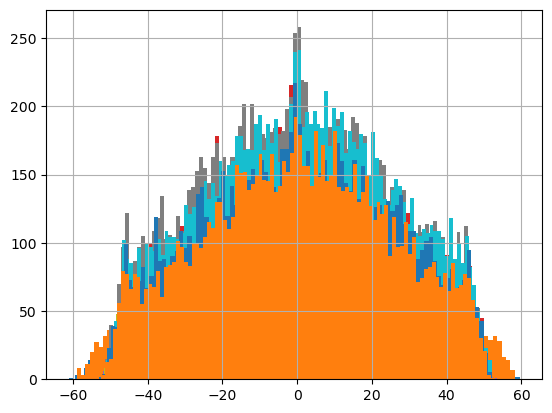

In [668]:
# age groups
ages = df_passes.groupby('age')

pos_vars = ['start_position_x', 'end_position_x', 'start_position_y', 'end_position_y']

for i, (age, age_df) in enumerate(ages):

    int_levels = age_df.groupby('int_level')

    # axes indexing
    if i > 2:
        i += 3

    for int_val, int_level_df in int_levels:
        title = f"Age group {age}, {['domestic', 'international'][int_val]}"
        # invert away passes to also attack to the right
        int_level_df.loc[away_mask, pos_vars] = int_level_df.loc[away_mask, pos_vars]*(-1)
        # bin_statistic = pitch.bin_statistic(int_level_df.start_position_x, int_level_df.start_position_y, statistic='count', bins=(11, 7))
        # pcm = pitch.heatmap(bin_statistic, ax=pitch_axes[i], cmap='hot', edgecolors='#22312b')
        int_level_df['start_position_x'].hist(bins=100)
        i += 3

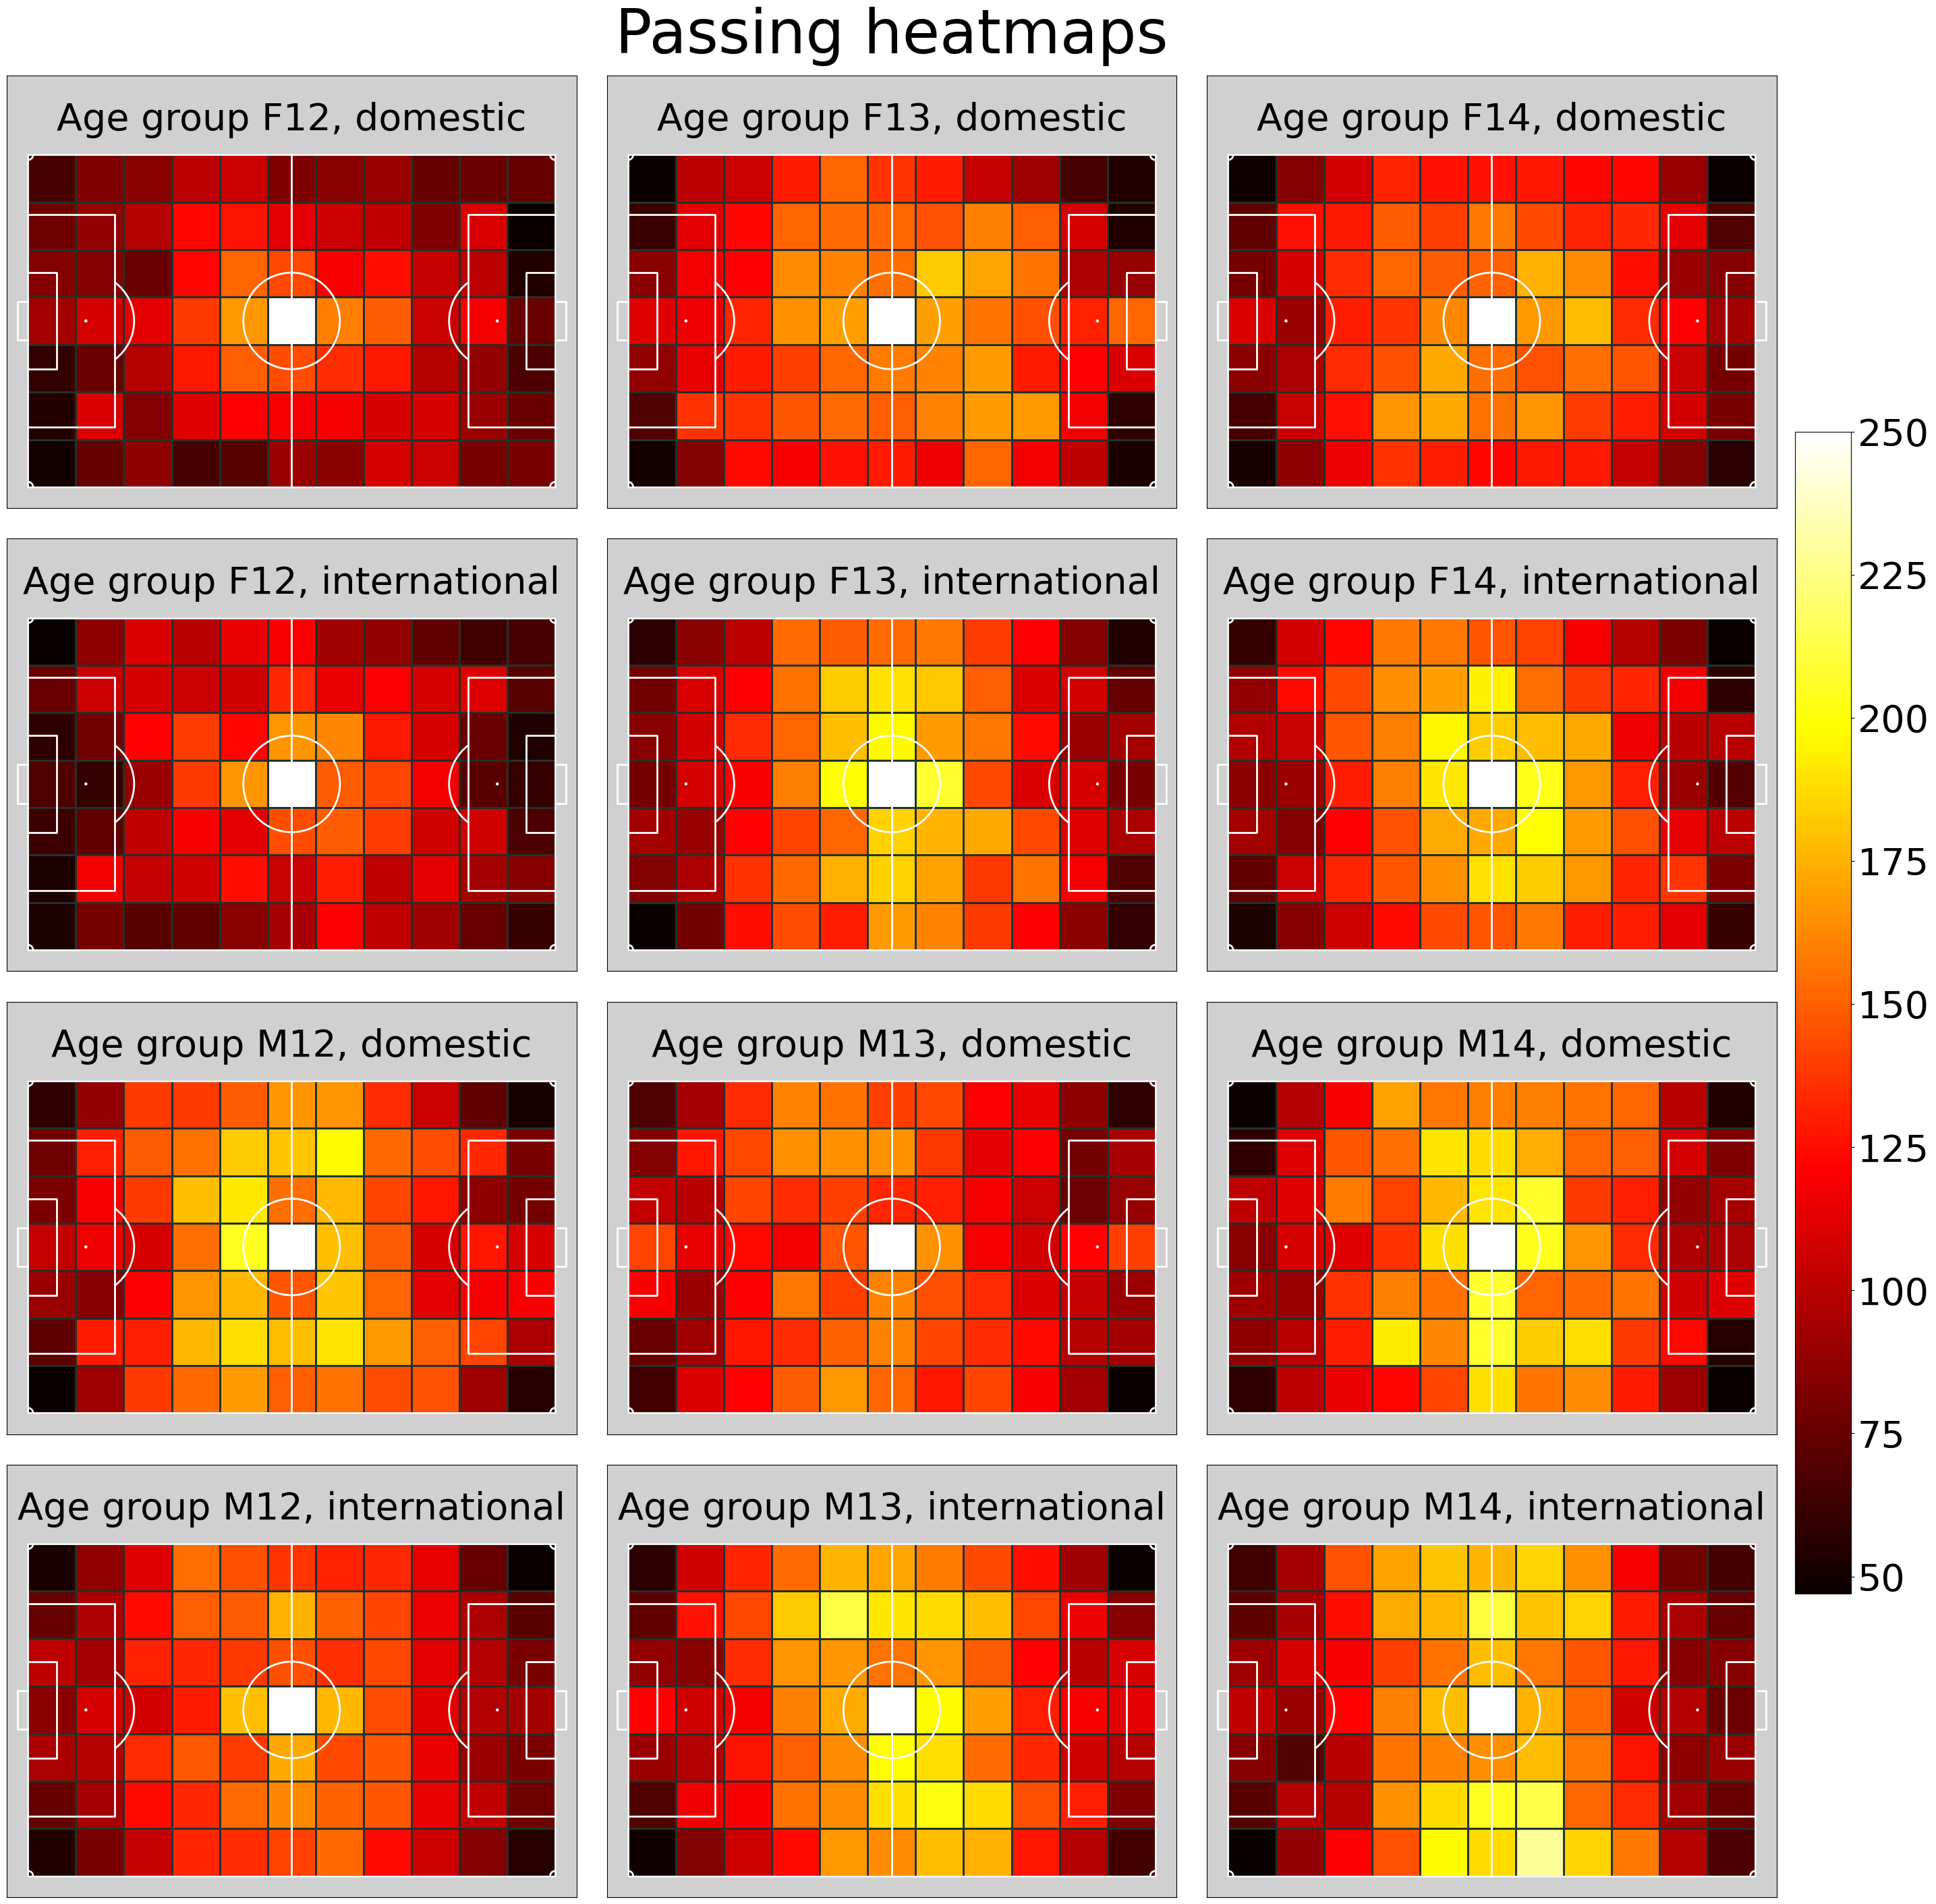

In [669]:
# plot possessional average tempos by age group and team internationality

# age groups
ages = df_passes.groupby('age')

pitch = create_pitch(15)
fig, axes = pitch.grid(nrows=4, ncols=3, figheight=30, axis=False,
                       title_height=0.008, title_space=0, grid_height=0.9,
                       endnote_height=0, endnote_space=0)

pitch_axes = axes['pitch'].flat

# init positional variable names
pos_vars = ['start_position_x', 'end_position_x', 'start_position_y', 'end_position_y']

ax_title_font_size = 40
sup_title_font_size = 65

for i, (age, age_df) in enumerate(ages):

    int_levels = age_df.groupby('int_level')

    # axes indexing
    if i > 2:
        i += 3

    for int_val, int_level_df in int_levels:
        title = f"Age group {age}, {['domestic', 'international'][int_val]}"
        pitch_axes[i].text(0, 38, title, ha='center', va='center', fontsize=ax_title_font_size)
        # invert away passes to also attack to the right
        int_level_df.loc[away_mask, pos_vars] = int_level_df.loc[away_mask, pos_vars]*(-1)
        bin_statistic = pitch.bin_statistic(int_level_df.start_position_x, int_level_df.start_position_y, statistic='count', bins=(11, 7))
        pcm = pitch.heatmap(bin_statistic, ax=pitch_axes[i], cmap='hot', edgecolors='#22312b')
        
        i += 3
    
# Add the colorbar and format off-white
# add cbar axes
cbar_bottom = axes['pitch'][-1, 0].get_position().y0 + 0.15
cbar_left = axes['pitch'][0, -1].get_position().x1 + 0.01
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, 0.03,
                        # take a little bit off the height because of padding
                        0.91 - 0.336))
cbar = plt.colorbar(pcm, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(ax_title_font_size)
fig.suptitle('Passing heatmaps', fontsize=sup_title_font_size)
plt.show()

Kick-offs should be filtered, otherwise looks good.

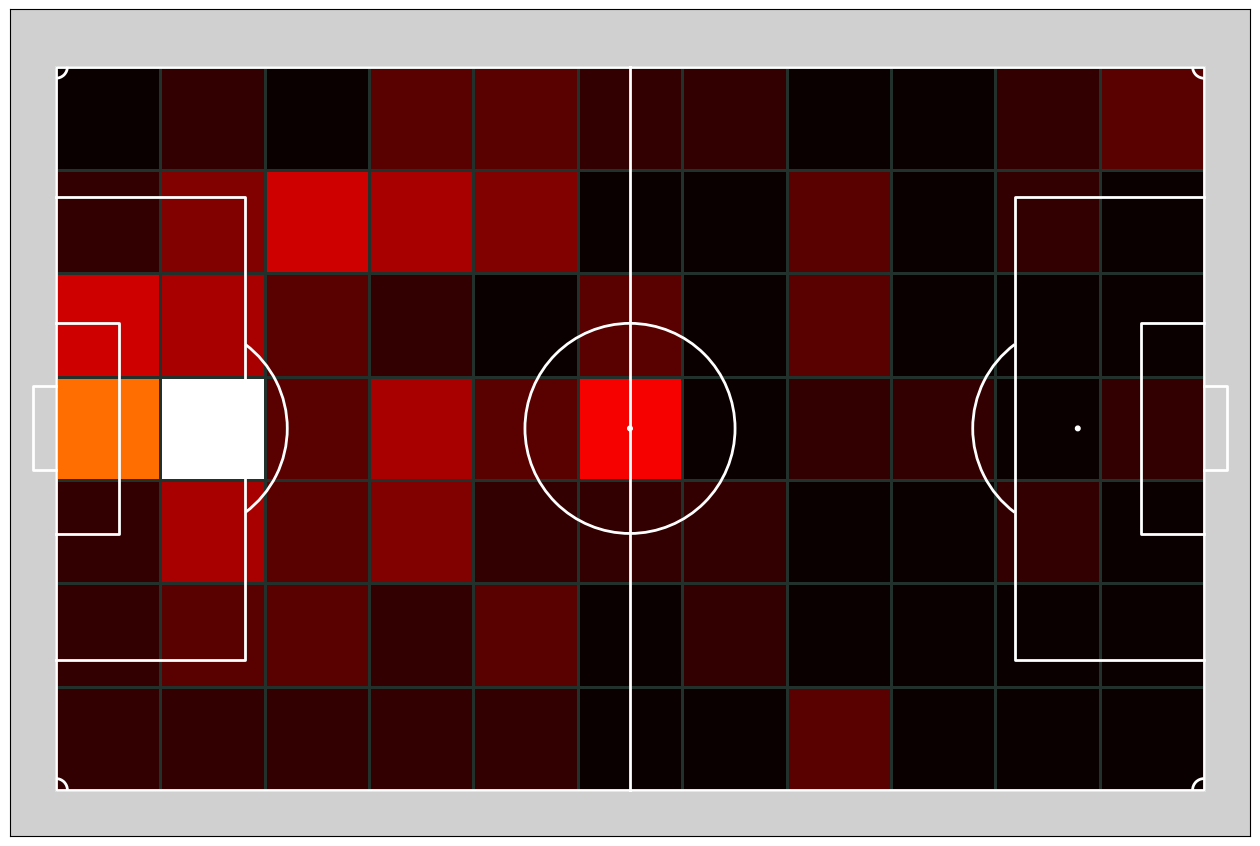

In [670]:
# Plot the completed passes
pitch = create_pitch(5)

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_passes_home_m14_int = df.loc[(df['event_type'] == 'Pass') & (df['team'] == 'Home') & (df['age'] == 'F12') & (df['int_level'] == 1)]
df_passes_home_m14_int = df.loc[(df['event_type'] == 'Pass') & (df['team'] == 'Home') & (df['match_id'] == 1254)]
df_passes_home_m14_dom = df.loc[(df['event_type'] == 'Pass') & (df['result'] == 'Successful') & (df['team'] == 'Home') & (df['age'] == 'M14') & (df['int_level'] == 0)]
# Plot the completed passes
bin_statistic = pitch.bin_statistic(df_passes_home_m14_int.start_position_x, df_passes_home_m14_int.start_position_y, statistic='count', bins=(11, 7))
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

In [671]:
df_passes_home_m14_int.loc[(df_passes_home_m14_int['start_position_x'] > -40) & (df_passes_home_m14_int['start_position_x'] < -36)]

tournament_id  match_id event_type  period       result  team  passer  \
1087             57      1254       Pass     1.0   Successful  Home  7362.0   
1096             57      1254       Pass     1.0   Successful  Home  7362.0   
1106             57      1254       Pass     1.0   Successful  Home  7362.0   
1131             57      1254       Pass     1.0   Successful  Home  7362.0   
1139             57      1254       Pass     1.0  Intercepted  Home  7358.0   
1150             57      1254       Pass     1.0   Successful  Home  7362.0   
1163             57      1254       Pass     1.0  Intercepted  Home  7362.0   
1172             57      1254       Pass     1.0   Successful  Home  7363.0   
1175             57      1254       Pass     1.0  Intercepted  Home  7362.0   
1182             57      1254       Pass     1.0   Successful  Home  7362.0   
1196             57      1254       Pass     1.0   Successful  Home  7362.0   
1237             57      1254       Pass     1.0   Successful  Home  7362.0   
1241             57      1254       Pass     1.0   Successful  Home  7362.0   
1252             57      1254       Pass     1.0   Successful  Home  7362.0   
1267             57      1254       Pass     1.0  Intercepted  Home  7351.0   
1271             57      1254       Pass     1.0   Successful  Home  7362.0   
1362             57      1254       Pass     2.0   Successful  Home  7363.0   
1407             57      1254       Pass     2.0   Successful  Home  7362.0   
1447             57      1254       Pass     2.0   Successful  Home  7354.0   
1560             57      1254       Pass     2.0  Intercepted  Home  7354.0   

      player  seconds_from_period_start                        start_time  \
1087     NaN                      115.0  2022-11-22 07:03:46.720000+00:00   
1096     NaN                      166.0  2022-11-22 07:04:37.420000+00:00   
1106     NaN                      216.0  2022-11-22 07:05:27.400000+00:00   
1131     NaN                      350.0  2022-11-22 07:07:41.680000+00:00   
1139     NaN                      369.0  2022-11-22 07:07:59.980000+00:00   
1150     NaN                      424.0  2022-11-22 07:08:55.720000+00:00   
1163     NaN                      477.0  2022-11-22 07:09:47.800000+00:00   
1172     NaN                      507.0  2022-11-22 07:10:18.680000+00:00   
1175     NaN                      531.0  2022-11-22 07:10:42.080000+00:00   
1182     NaN                      565.0  2022-11-22 07:11:16.360000+00:00   
1196     NaN                      656.0  2022-11-22 07:12:46.820000+00:00   
1237     NaN                      889.0  2022-11-22 07:16:40.600000+00:00   
1241     NaN                      911.0  2022-11-22 07:17:02.240000+00:00   
1252     NaN                      967.0  2022-11-22 07:17:58.740000+00:00   
1267     NaN                     1026.0  2022-11-22 07:18:57.320000+00:00   
1271     NaN                     1045.0  2022-11-22 07:19:16.580000+00:00   
1362     NaN                     1479.0  2022-11-22 07:32:21.360000+00:00   
1407     NaN                     1679.0  2022-11-22 07:35:40.880000+00:00   
1447     NaN                     1805.0  2022-11-22 07:37:47.300000+00:00   
1560     NaN                     2203.0  2022-11-22 07:44:25.140000+00:00   

      ...   home_team  away_team  home_team_int  away_team_int  age  year  \
1087  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1096  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1106  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1131  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1139  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1150  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1163  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1172  ...  KuPS T2010  HJK T2010              0              0  F12  2022   
1175  ...  KuPS T2010  HJK T2010   

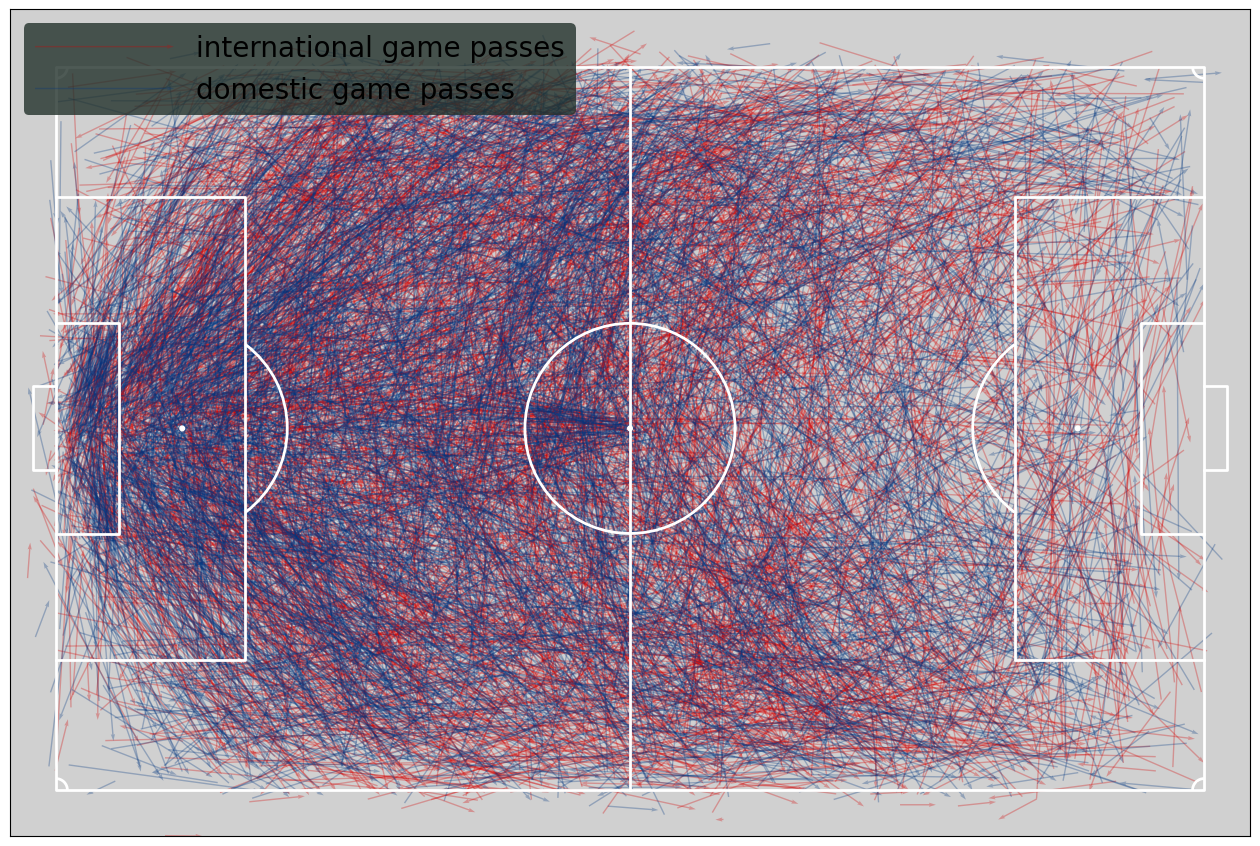

In [672]:
# Plot the completed passes
pitch = create_pitch(5)

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_passes_home_m14_int = df.loc[(df['event_type'] == 'Pass') & (df['result'] == 'Successful') & (df['team'] == 'Home') & (df['age'] == 'M14') & (df['int_level'] == 1)]
df_passes_home_m14_dom = df.loc[(df['event_type'] == 'Pass') & (df['result'] == 'Successful') & (df['team'] == 'Home') & (df['age'] == 'M14') & (df['int_level'] == 0)]

# Plot the completed passes
pitch.arrows(df_passes_home_m14_int.start_position_x, df_passes_home_m14_int.start_position_y,
             df_passes_home_m14_int.end_position_x, df_passes_home_m14_int.end_position_y,
             width=1, color='#d50000', alpha=0.3, ax=ax, label='international game passes')

pitch.arrows(df_passes_home_m14_dom.start_position_x, df_passes_home_m14_dom.start_position_y,
             df_passes_home_m14_dom.end_position_x, df_passes_home_m14_dom.end_position_y,
             width=1, color='#003580', alpha=0.3, ax=ax, label='domestic game passes')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=20, loc='upper left')

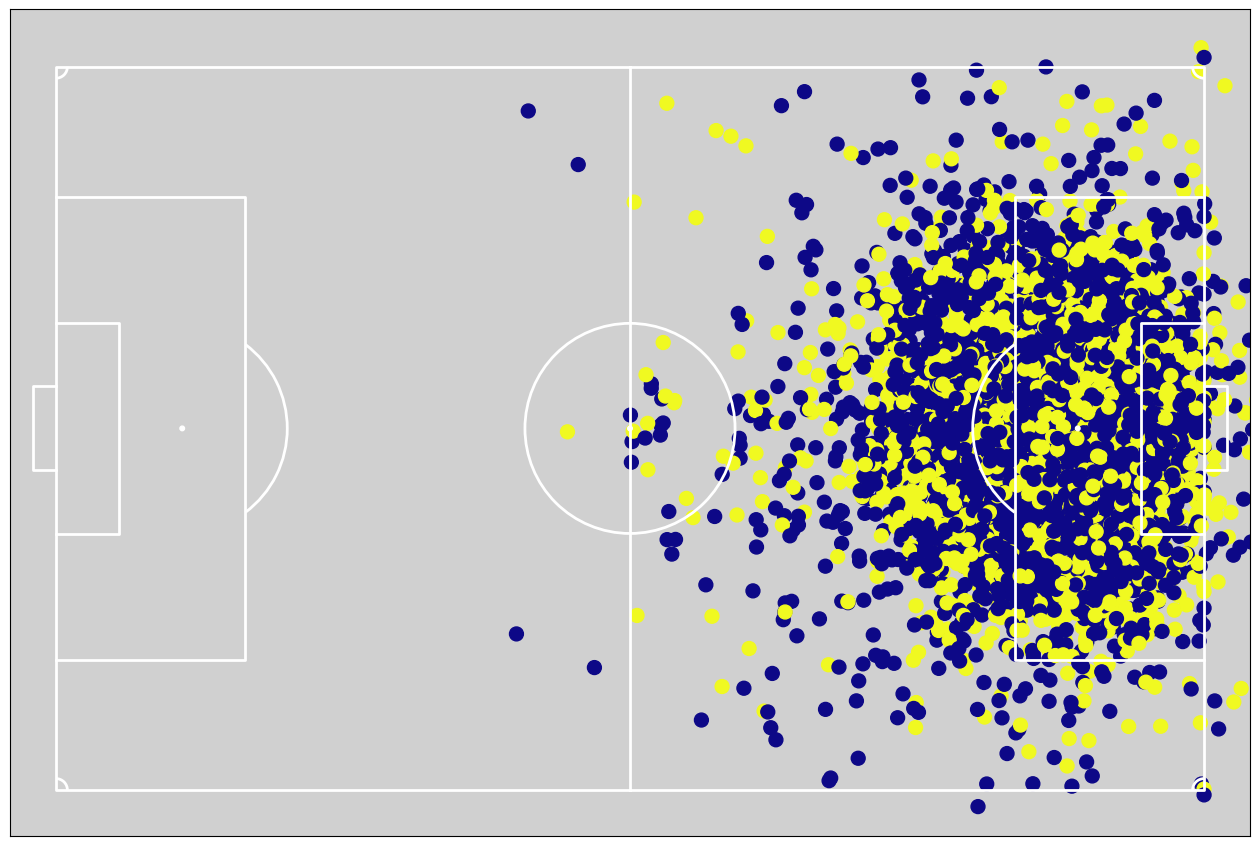

In [673]:
# plot some shots
df_shots = df[df['event_type'] == 'Shot']

pitch = create_pitch(5)

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_shots_home = df_shots.loc[(df_shots['team'] == 'Home')]
df_shots_away = df_shots.loc[(df_shots['team'] == 'Away')]

# Plot the completed passes
pitch.scatter(df_shots_home.start_position_x, df_shots_home.start_position_y,
             s=100, cmap='plasma_r', c=df_shots_home.int_level, ax=ax)
pitch.scatter(df_shots_away.start_position_x*(-1), df_shots_away.start_position_y*(-1),
             s=100, cmap='plasma_r', c=df_shots_away.int_level, ax=ax)

In [674]:
# df[(df['match_id'] == 2247) & (df['event_type'] == 'Shot')]

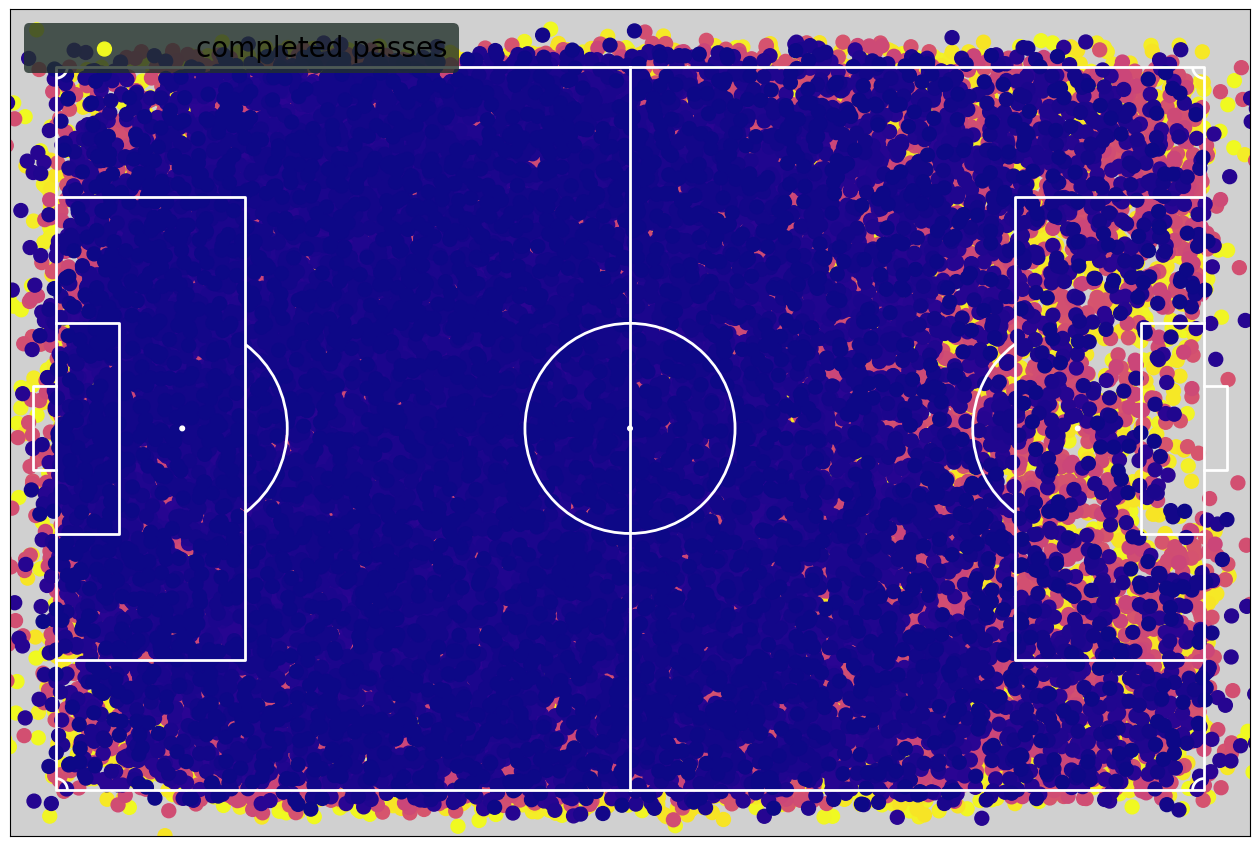

In [675]:
pitch = create_pitch(5)

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_passes_home = df_passes[df_passes['team'] == 'Home']


# Plot the completed passes
pitch.scatter(df_passes_home.start_position_x, df_passes_home.start_position_y,
             s=100, cmap='plasma_r', c=df_passes_home.tournament_id, ax=ax, label='completed passes')


# Set up the legend
ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=20, loc='upper left')

In [676]:
matches = pd.read_csv('../data/match_info.csv')
dimensions = pd.read_csv('../data/pitch_dimensions.csv')

In [677]:
matches = matches.drop(columns=['home_team_int', 'away_team_int', 'int_level'])

In [678]:
comb = matches.merge(dimensions, on='match_id', how='inner')

In [679]:
comb[['age', 'pitch_length', 'pitch_width']].value_counts().reset_index(name='count')

age  pitch_length  pitch_width  count
0  M14           100           63     87
1  M12           100           63     82
2  F14           100           63     74
3  F13           100           63     68
4  M13           100           63     65
5  F12            63           40     54